In [1]:
# Import packages
import cmath
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.layers import LSTMCell
from tensorflow.python.keras import activations
from tensorflow.python.ops import array_ops
import tensorflow_addons as tfa
tf.executing_eagerly()

True

In [2]:
# Custom LSTM class
class DenseLSTMCell(LSTMCell):

    def __init__(self,
        units,
        activation='tanh',
        recurrent_activation='hard_sigmoid',
        dense_activation='tanh',
        use_bias=True,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal',
        bias_initializer='zeros',
        unit_forget_bias=True,
        kernel_regularizer=None,
        recurrent_regularizer=None,
        bias_regularizer=None,
        kernel_constraint=None,
        recurrent_constraint=None,
        bias_constraint=None,
        dropout=0.,
        recurrent_dropout=0.,
        **kwargs):
        super(DenseLSTMCell, self).__init__(
            units,
            activation=activation,
            recurrent_activation=recurrent_activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            recurrent_initializer=recurrent_initializer,
            bias_initializer=bias_initializer,
            unit_forget_bias=unit_forget_bias,
            kernel_regularizer=kernel_regularizer,
            recurrent_regularizer=recurrent_regularizer,
            bias_regularizer=bias_regularizer,
            kernel_constraint=kernel_constraint,
            recurrent_constraint=recurrent_constraint,
            bias_constraint=bias_constraint,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            implementation=kwargs.pop('implementation', 2),
            **kwargs)
        self.dense_activation = activations.get(dense_activation)
        self.state_size = [self.units, self.units]
        self.output_size = self.units
    
    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(input_dim, self.units * 5),
            name='kernel',
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint)
        
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 5),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)
        
        if self.use_bias:
            if self.unit_forget_bias:
                def bias_initializer(_, *args, **kwargs):
                    return K.concatenate([
                      self.bias_initializer((self.units,), *args, **kwargs),
                      keras.initializers.get('ones')((self.units,), *args, **kwargs),
                      self.bias_initializer((self.units * 3,), *args, **kwargs),
                  ])
            else:
                bias_initializer = self.bias_initializer
            self.bias = self.add_weight(shape=(self.units * 5,),
              name='bias',
              initializer=bias_initializer,
              regularizer=self.bias_regularizer,
              constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.dense_kernel = self.add_weight(
            shape=(self.output_size, 3),
            name='dense_kernel',
            initializer='zeros')
        
        self.dense_bias = self.add_weight(
            shape=(3,),
            name='dense_kernel',
            initializer='zeros')
        
        self.built = True
    
    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory state
        c_tm1 = states[1]  # previous carry state
        
        z = K.dot(inputs, self.kernel)
        if self.use_bias:
            z = K.bias_add(z, self.bias)

        x_i, x_f, x_c, x_o, x_m = array_ops.split(z, num_or_size_splits=5, axis=1)
        (self.recurrent_kernel_i,
        self.recurrent_kernel_f,
        self.recurrent_kernel_c,
        self.recurrent_kernel_o,
        self.recurrent_kernel_m) = array_ops.split(self.recurrent_kernel, num_or_size_splits=5, axis=1)
        
        m = x_m * K.dot(h_tm1, self.recurrent_kernel_m)
        
        # m = x_m * K.dot(h_tm1, self.recurrent_kernel_m)
        i = self.recurrent_activation(x_i + K.dot(m, self.recurrent_kernel_i))
        f = self.recurrent_activation(x_f + K.dot(m, self.recurrent_kernel_f))
        c = f * c_tm1 + i * self.activation(x_c + K.dot(m, self.recurrent_kernel_c))
        o = self.recurrent_activation(x_o + K.dot(m, self.recurrent_kernel_o))

        h = o * self.activation(c)
        factor = tf.math.abs(tf.math.sign(tf.reshape(tf.reduce_sum(inputs, axis=1), shape=(-1, 1))))
        h_dense = tf.math.multiply(factor, tf.matmul(h, self.dense_kernel) + self.dense_bias)
        # h_dense = self.dense_activation(tf.math.multiply(factor, tf.matmul(h, self.dense_kernel) + self.dense_bias))
        return h_dense, [h, c]

In [3]:
# Define constants
cos_const = tf.constant([[1., 0., 0., 1.]], dtype=tf.complex64)
sin_const = tf.constant([[0., -1., 1., 0.]], dtype=tf.complex64)
phi_const = 1j * tf.constant([[0., 0., 1., 1.]], dtype=tf.complex64)
lam_const = 1j * tf.constant([[0., 1., 0., 1.]], dtype=tf.complex64)

# Define U3 gates in Tensorflow
def tf_u3(thetas, phis, lamdas, batch_size, num_mats):
    cos_mat = tf.matmul(tf.math.cos(thetas/2), cos_const)
    sin_mat = tf.matmul(tf.math.sin(thetas/2), sin_const)
    trig_mat = tf.add(cos_mat, sin_mat)
    exp_mat = tf.math.exp(tf.add(tf.matmul(phis, phi_const), tf.matmul(lamdas, lam_const)))
    param_mat = tf.math.multiply(trig_mat, exp_mat)
    u3_mat = tf.reshape(param_mat, shape=(batch_size, num_mats, 2, 2))
    return u3_mat

# Transform gate parameters to U3 gate
def tensor_to_u3(X_in, batch_size, num_mats):
    X_in = tf.cast(X_in, dtype=tf.complex64)
    return tf_u3(*tf.split(X_in, num_or_size_splits=3, axis=2), batch_size, num_mats)

# Alternate applied and noisy gates
def alternate_gates(applied, noise, batch_size, num_mats):
    applied_expand = tf.expand_dims(applied, 2)
    noise_expand = tf.expand_dims(noise, 2)
    seq = tf.reshape(tf.concat((applied_expand, noise_expand), 2), shape=(batch_size, 2 * num_mats, 2, 2))
    return seq

# Reduce tensor by taking matrix product along axis 1
def reduce_mat_prod(X_in, batch_size, num_mats):
    mat_splice = tf.split(X_in, num_or_size_splits=num_mats, axis=1)
    result = mat_splice[0]
    for k in range(1, num_mats):
        result = tf.matmul(mat_splice[k], result)
    return tf.squeeze(result)

# Return fidelity from oepration matrix
def get_fid(final_ops):
    fids = tf.square(tf.abs(final_ops[:,0][:,0:1]))
    return fids

In [4]:
# Define U3 gate
def u3_matrix(theta, phi, lamda):
    return np.array([[np.cos(theta/2),                  -cmath.exp(1j*lamda)*np.sin(theta/2)],
                    [cmath.exp(1j*phi)*np.sin(theta/2), cmath.exp(1j*(phi+lamda))*np.cos(theta/2)]])

# Transform gate parameters to U3 gate
def matrix_transform(X_in):
    X = [[u3_matrix(*parameter_list[3*k:3*k+3]) for k in range(len(parameter_list)//3)] for parameter_list in X_in]
    return tf.constant(X, dtype=tf.complex64)

# Create parameters
def params(num, theta, phi, lamda, num_params):
    if theta == 0.0 and phi == 0.0 and lamda == 0.0:
        return [0.0] * num_params
    return np.array([num, theta, phi, lamda, theta**2/2, phi**2/2, lamda**2/2,
                     np.cos(theta/2), np.sin(theta/2),
                     np.sin(theta/2) * np.cos(phi), np.sin(theta/2) * np.sin(phi),
                     np.sin(theta/2) * np.cos(lamda), np.sin(theta/2) * np.sin(lamda),
                     np.cos(theta/2) * np.cos(phi + lamda), np.cos(theta/2) * np.sin(phi + lamda)])

# Transform theta, phi, lambda parameters
def param_transform(X_in, num_params):
    p_length = len(X_in[0])//3
    X = [[params((k+1)/p_length, *parameter_list[3*k:3*k+3], num_params) for k in range(p_length)] for parameter_list in X_in]
    return np.array(X)
    
# Load data from data set
def load_data(num_gates, num_params):
    with open('..//..//Data Collection//Yorktown//dataset_york.p', 'rb') as f:
        data_set = pk.load(f)
    X, Y = param_transform(np.array(data_set['X']), num_params), np.array(data_set['Y'])
    X, Y = X.reshape(len(X), num_gates, num_params), Y.reshape(len(Y), 1)
    data = (train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42))
    return data

# Augment output tensor by adding input gate elements
def augment_y(X_in, Y_in, num_gates):
    data_size = len(X_in)
    X_in = tf.constant(X_in[:,:,0:3], dtype=tf.float32)
    X_in_reshape = tf.reshape(X_in, shape=(data_size, 3 * num_gates))
    X_in_mat = matrix_transform(X_in_reshape.numpy())
    X_in_mat_reshape = tf.reshape(X_in_mat, shape=(data_size, 1, 4 * num_gates))
    Y_in = tf.cast(tf.concat((Y_in, X_in_mat_reshape[:,0]), axis=1), dtype=tf.complex64)
    return Y_in

In [5]:
# Load data
num_gates = 100
num_params = 15
data = load_data(num_gates, num_params)
x_train, x_test, y_train, y_test = data
x_train = tf.constant(x_train, dtype=tf.float32)
x_test = tf.constant(x_test, dtype=tf.float32)

# Augment output
y_train = augment_y(x_train[:,:, 1:], y_train, num_gates)
y_test = augment_y(x_test[:,:, 1:], y_test, num_gates)

In [6]:
# Define custom loss function by alternating applied and noisy gates, then multiplying matrices
def loss(y_true, y_pred):
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    batch_size = tf.cast(len(y_true), dtype=tf.float32)

    fid = tf.cast(y_true[:,0:1], dtype=tf.float32)
    u3_elems = y_true[:,1:]
    
    # Create applied and noisy gates
    applied = tf.reshape(u3_elems, shape=(batch_size, num_gates, 2, 2))
    noise = tensor_to_u3(y_pred, batch_size, num_gates)

    # Alternate applied and noisy gates and calculate reduced matrix product
    seq = alternate_gates(applied, noise, batch_size, num_gates)    
    ops = reduce_mat_prod(seq, batch_size, 2 * num_gates)
    fid_pred = get_fid(ops)
    
    cost = tf.divide(tf.reduce_sum(tf.square(fid-fid_pred)), batch_size)
    return tf.sqrt(cost)

# LSTM model
model = keras.models.Sequential([
    keras.Input(shape=(None, num_params)),
    keras.layers.Conv1DTranspose(64, 1, activation='tanh'),
    keras.layers.LSTM(units=32, input_shape=(None, 32), activation='tanh', return_sequences=True),
    keras.layers.LSTM(units=32, input_shape=(None, 32), activation='tanh', return_sequences=True),
    keras.layers.RNN(DenseLSTMCell(units=32, input_shape=(None, 32), activation='tanh', dense_activation='tanh'), 
                     return_sequences=True)
])

# Building model
optimizer = keras.optimizers.Adam(learning_rate=5e-5)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_transpose (Conv1DTran (None, None, 64)          1024      
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          12416     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
rnn (RNN)                    (None, None, 3)           10499     
Total params: 32,259
Trainable params: 32,259
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Train
model.fit(x_train, y_train, epochs=2, validation_data=(x_test, y_test))

Epoch 1/2
250/250 [==============================] - 24s 95ms/step - loss: 0.0644 - val_loss: 0.0646
Epoch 2/2
250/250 [==============================] - 23s 92ms/step - loss: 0.0644 - val_loss: 0.0645


In [9]:
def num_of_gates(X):
    count = 0
    while count < 100 and X[count][1] != 0.0 and X[count][2] != 0.0 and X[count][3] != 0.0:
        count += 1
    return count

# Define non-batched loss function
def list_loss(y_true, y_pred):
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    batch_size = tf.cast(len(y_true), dtype=tf.float32)

    fid = tf.cast(y_true[:,0:1], dtype=tf.float32)
    u3_elems = y_true[:,1:]
    
    applied = tf.reshape(u3_elems, shape=(batch_size, num_gates, 2, 2))
    noise = tensor_to_u3(y_pred, batch_size, num_gates)

    seq = alternate_gates(applied, noise, batch_size, num_gates)    
    ops = reduce_mat_prod(seq, batch_size, 2 * num_gates)
    fid_pred = get_fid(ops)
    return fid_pred

# Concatenate data
x_all = np.concatenate([x_train, x_test])
y_all = np.concatenate([y_train, y_test])
noisy_gates = model.predict(x_all)
y_predict = list_loss(y_all, noisy_gates)

# Calculate fidelity difference: expected - predicted
fid_dict = {}
for k in range(100):
    fid_dict[k+1] = []   
for k in range(len(y_predict)):
    g = num_of_gates(x_all[k])
    fid_dict[g].append(y_all[k][0].real - y_predict[k][0])

In [10]:
# Evaluate model
rmse_rnn = []
for k in range(1,99):
    temp = np.array(fid_dict[k+1])
    x = np.sqrt(np.sum(temp**2)/len(temp))
    rmse_rnn.append(x)
print(sum(rmse_rnn)/100)

0.06314855986002327


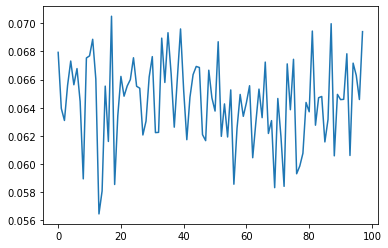

In [11]:
# Plot data
plt.plot(rmse_rnn)

In [12]:
# Save data
pk.dump(rmse_rnn, open('rnn_york_rmse.p', 'wb'))